In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np

In [ ]:
# Define Dataset Class
class CricketDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['Insights']
        numerical_features = row[['match_performance']].values.astype(np.float32)
        target = row['predicted_future_performance']

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'numerical_features': torch.tensor(numerical_features, dtype=torch.float),
            'target': torch.tensor(target, dtype=torch.float)
        }


In [ ]:



# Define the Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, transformer_name, num_numerical_features):
        super(TransformerModel, self).__init__()
        self.bert = BertModel.from_pretrained(transformer_name)
        self.fc_numerical = nn.Linear(num_numerical_features, 128)
        self.fc_combined = nn.Linear(self.bert.config.hidden_size + 128, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, numerical_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.pooler_output

        numerical_features = self.fc_numerical(numerical_features)
        numerical_features = torch.relu(numerical_features)

        combined_features = torch.cat((text_features, numerical_features), dim=1)
        combined_features = self.dropout(combined_features)

        output = self.fc_combined(combined_features)
        return output

In [ ]:
data = pd.read_csv('/kaggle/input/sentiment-data-1/player_performance_with_embeddings_final1_updated_final.csv')


In [ ]:
print(data.head())

In [ ]:
# Load Data
data = data.dropna(subset=['Insights', 'match_performance', 'predicted_future_performance'])

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset and DataLoader
MAX_LEN = 128
BATCH_SIZE = 16

dataset = CricketDataset(data, tokenizer, MAX_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model Initialization
NUM_NUMERICAL_FEATURES = 1
model = TransformerModel(transformer_name='bert-base-uncased', num_numerical_features=NUM_NUMERICAL_FEATURES)
model = model.to('cuda')

# Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

# Training Loop
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        numerical_features = batch['numerical_features'].to('cuda')
        targets

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim

# Load datasets
df_player_performance = pd.read_csv('/kaggle/input/sentiment-data-1/player_performance_with_embeddings_final1_updated_final.csv')
df_match_performance = pd.read_csv('/kaggle/input/sentiment-data-1/ipl-2008_2022-player_scores-updated.csv')

# Preprocessing: Merge datasets
df_player_performance['date'] = pd.to_datetime(df_player_performance['date'])
df_match_performance['match_date'] = pd.to_datetime(df_match_performance['match_date'])

# Align player names and dates
merged_data = pd.merge(
    df_player_performance,
    df_match_performance,
    left_on=['player_name', 'date'],
    right_on=['player', 'match_date'],
    how='inner'
)

# Select relevant columns for modeling
merged_data = merged_data[['player_name', 'Metrics', 'Insights', 'Arguments', 'match_performance', 'total_points']]

# Dataset class
class CricketDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['Insights']
        numerical_features = row[['match_performance']].values.astype(float)
        target = row['total_points']

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'numerical_features': torch.tensor(numerical_features, dtype=torch.float),
            'target': torch.tensor(target, dtype=torch.float)
        }

# Transformer model
class TransformerModel(nn.Module):
    def __init__(self, transformer_name, num_numerical_features):
        super(TransformerModel, self).__init__()
        self.bert = BertModel.from_pretrained(transformer_name)
        self.fc_numerical = nn.Linear(num_numerical_features, 128)
        self.fc_combined = nn.Linear(self.bert.config.hidden_size + 128, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, numerical_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.pooler_output

        numerical_features = self.fc_numerical(numerical_features)
        numerical_features = torch.relu(numerical_features)

        combined_features = torch.cat((text_features, numerical_features), dim=1)
        combined_features = self.dropout(combined_features)

        output = self.fc_combined(combined_features)
        return output

# Tokenizer and DataLoader
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 16

dataset = CricketDataset(merged_data, tokenizer, MAX_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model Initialization
model = TransformerModel(transformer_name='bert-base-uncased', num_numerical_features=1).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

# Training Loop
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        numerical_features = batch['numerical_features'].to('cuda')
        targets = batch['target'].to('cuda')

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, numerical_features)
        loss = loss_fn(outputs.squeeze(-1), targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(dataloader):.4f}")


In [ ]:
 print(df_player_performance[['player_name', 'date']].head())
print(df_match_performance[['player', 'match_date']].head())


In [ ]:
import pandas as pd
import numpy as np

# Load datasets
df_player_performance = pd.read_csv('/kaggle/input/sentiment-data-1/player_performance_with_embeddings_final1_updated_final.csv')
df_match_performance = pd.read_csv('/kaggle/input/sentiment-data-1/ipl-2008_2022-player_scores-updated.csv')

# Normalize player names
df_player_performance['player_name'] = df_player_performance['player_name'].str.strip().str.lower()
df_match_performance['player'] = df_match_performance['player'].str.strip().str.lower()

# Parse dates with specified formats
df_player_performance['date'] = pd.to_datetime(df_player_performance['date'], format='%Y-%m-%d')
df_match_performance['match_date'] = pd.to_datetime(df_match_performance['match_date'], format='%m/%d/%y')

# Split names into first and last names
def split_name(name):
    parts = name.split("_")
    return parts[0], parts[-1]

df_player_performance[['first_name', 'last_name']] = df_player_performance['player_name'].apply(lambda x: pd.Series(split_name(x)))
df_match_performance[['first_name', 'last_name']] = df_match_performance['player'].apply(lambda x: pd.Series(split_name(x)))

# Merge based on first or last name with date flexibility
merged_data = []
date_tolerance = pd.Timedelta(days=7)

for _, row in df_player_performance.iterrows():
    player_first_name = row['first_name']
    player_last_name = row['last_name']
    article_date = row['date']

    # Filter match data for the same first or last name
    player_matches = df_match_performance[
        (df_match_performance['first_name'] == player_first_name) |
        (df_match_performance['last_name'] == player_last_name)
    ]

    if not player_matches.empty:
        # Find closest match date within the tolerance
        player_matches['date_diff'] = abs(player_matches['match_date'] - article_date)
        closest_match = player_matches[player_matches['date_diff'] <= date_tolerance]

        if not closest_match.empty:
            best_match = closest_match.loc[closest_match['date_diff'].idxmin()]
            merged_row = {
                'player_name': row['player_name'],
                'Metrics': row['Metrics'],
                'Insights': row['Insights'],
                'Arguments': row['Arguments'],
                'match_performance': row['match_performance'],
                'match_date': best_match['match_date'],
                'total_points': best_match['total_points'],
                'Metrics_embeddings': row['Metrics_embeddings'],
                'Insights_embeddings' : row['Insights_embeddings'],
                'Arguments_embeddings': row['Arguments_embeddings']
            }
            merged_data.append(merged_row)

# Convert merged data to DataFrame
merged_data = pd.DataFrame(merged_data)

# Check results
print("Merged Data Shape:", merged_data.shape)
print(merged_data.head())

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim

# Dataset class
class CricketDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['Insights']
        numerical_features = row[['match_performance']].values.astype(float)
        target = row['total_points']

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'numerical_features': torch.tensor(numerical_features, dtype=torch.float),
            'target': torch.tensor(target, dtype=torch.float)
        }

# Transformer model
class TransformerModel(nn.Module):
    def __init__(self, transformer_name, num_numerical_features):
        super(TransformerModel, self).__init__()
        self.bert = BertModel.from_pretrained(transformer_name)
        self.fc_numerical = nn.Linear(num_numerical_features, 128)
        self.fc_combined = nn.Linear(self.bert.config.hidden_size + 128, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, numerical_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.pooler_output

        numerical_features = self.fc_numerical(numerical_features)
        numerical_features = torch.relu(numerical_features)

        combined_features = torch.cat((text_features, numerical_features), dim=1)
        combined_features = self.dropout(combined_features)

        output = self.fc_combined(combined_features)
        return output

# Tokenizer and DataLoader
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 2

dataset = CricketDataset(merged_data, tokenizer, MAX_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model Initialization
model = TransformerModel(transformer_name='bert-base-uncased', num_numerical_features=1).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

# Training Loop
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        numerical_features = batch['numerical_features'].to('cuda')
        targets = batch['target'].to('cuda')

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, numerical_features)
        loss = loss_fn(outputs.squeeze(-1), targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(dataloader):.4f}")

# Testing Function
def test_model(model, dataloader):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            numerical_features = batch['numerical_features'].to('cuda')
            targets = batch['target'].to('cuda')

            outputs = model(input_ids, attention_mask, numerical_features)
            predictions.extend(outputs.squeeze(-1).cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    return predictions, actuals

# Testing the Model
predictions, actuals = test_model(model, dataloader)
print("Testing Complete!")


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim

# Dataset class
class CricketDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['Insights']
        numerical_features = row[['match_performance']].values.astype(float)
        target = row['total_points']

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'numerical_features': torch.tensor(numerical_features, dtype=torch.float),
            'target': torch.tensor(target, dtype=torch.float)
        }

# Enhanced Transformer model
class EnhancedTransformerModel(nn.Module):
    def __init__(self, transformer_name, num_numerical_features):
        super(EnhancedTransformerModel, self).__init__()
        self.bert = BertModel.from_pretrained(transformer_name)
        
        # Layers for text embeddings
        self.text_fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.text_fc2 = nn.Linear(256, 128)
        
        # Layers for numerical features
        self.fc_numerical1 = nn.Linear(num_numerical_features, 128)
        self.fc_numerical2 = nn.Linear(128, 64)
        
        # Combined layers
        self.fc_combined1 = nn.Linear(128 + 64, 128)
        self.fc_combined2 = nn.Linear(128, 64)
        self.fc_output = nn.Linear(64, 1)
        
        # Dropout
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, numerical_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.pooler_output

        # Process text features
        text_features = torch.relu(self.text_fc1(text_features))
        text_features = torch.relu(self.text_fc2(text_features))

        # Process numerical features
        numerical_features = torch.relu(self.fc_numerical1(numerical_features))
        numerical_features = torch.relu(self.fc_numerical2(numerical_features))

        # Combine features
        combined_features = torch.cat((text_features, numerical_features), dim=1)
        combined_features = torch.relu(self.fc_combined1(combined_features))
        combined_features = self.dropout(torch.relu(self.fc_combined2(combined_features)))

        # Output layer
        output = self.fc_output(combined_features)
        return output

# Tokenizer and DataLoader
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 2

dataset = CricketDataset(merged_data, tokenizer, MAX_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model Initialization
model = EnhancedTransformerModel(transformer_name='bert-base-uncased', num_numerical_features=1).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

# Training Loop
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        numerical_features = batch['numerical_features'].to('cuda')
        targets = batch['target'].to('cuda')

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, numerical_features)
        loss = loss_fn(outputs.squeeze(-1), targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(dataloader):.4f}")

# Testing Function
def test_model(model, dataloader):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            numerical_features = batch['numerical_features'].to('cuda')
            targets = batch['target'].to('cuda')

            outputs = model(input_ids, attention_mask, numerical_features)
            predictions.extend(outputs.squeeze(-1).cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    return predictions, actuals

# Testing the Model
predictions, actuals = test_model(model, dataloader)
print("Testing Complete!")

### MADDY WORK NOW 


In [ ]:
#update hte paths here @maddy 
# Load the three datasets
df_player_info = pd.read_csv("/kaggle/input/2008-data-for-testing/player_performance_with_embeddings_rows_from_2008-updated-final.csv")
df_match_scores = pd.read_csv("/kaggle/input/2008-data-for-testing/ipl-2008-player_scores-updated.csv")
df_match_metadata = pd.read_csv("/kaggle/input/2008-data-for-testing/updated-matches-dataset-eo2008.csv")

# Normalize player names and parse dates
df_player_info['player_name'] = df_player_info['player_name'].str.strip().str.lower()
df_match_scores['player'] = df_match_scores['player'].str.strip().str.lower()
df_player_info['date'] = pd.to_datetime(df_player_info['date'])
df_match_scores['match_date'] = pd.to_datetime(df_match_scores['match_date'])

# Merge player info and match scores on player names and dates
merged_data = pd.merge(
    df_player_info,
    df_match_scores,
    left_on=['player_name', 'date'],
    right_on=['player', 'match_date'],
    how='inner'
)

# Ensure 'date' and 'Date' columns are in datetime format
merged_data['date'] = pd.to_datetime(merged_data['date'], errors='coerce')
df_match_metadata['Date'] = pd.to_datetime(df_match_metadata['Date'], errors='coerce')

# Check for rows where the conversion failed
if merged_data['date'].isnull().any():
    print("Warning: Some rows in 'merged_data' have invalid dates.")
    print(merged_data[merged_data['date'].isnull()])
if df_match_metadata['Date'].isnull().any():
    print("Warning: Some rows in 'df_match_metadata' have invalid dates.")
    print(df_match_metadata[df_match_metadata['Date'].isnull()])

# Drop rows with invalid dates in either dataframe
merged_data = merged_data.dropna(subset=['date'])
df_match_metadata = df_match_metadata.dropna(subset=['Date'])

# Merge match metadata based on match date
merged_data = pd.merge(
    merged_data,
    df_match_metadata,
    left_on='date',
    right_on='Date',
    how='inner'
)
print(merged_data['date'].head())
print(df_match_metadata['Date'].head())



In [ ]:

#update hte paths here @maddy 
# Load the three datasets
df_player_info = pd.read_csv("/kaggle/input/sentiment-data-1/player_performance_with_embeddings_final1_updated_final.csv")
df_match_scores = pd.read_csv("/kaggle/input/2008-data-for-testing/ipl-2008-player_scores-updated.csv")
df_match_metadata = pd.read_csv("/kaggle/input/2008-data-for-testing/updated-matches-dataset-eo2008.csv")

# Normalize player names and parse dates
df_player_info['player_name'] = df_player_info['player_name'].str.strip().str.lower()
df_match_scores['player'] = df_match_scores['player'].str.strip().str.lower()
df_player_info['date'] = pd.to_datetime(df_player_info['date'])
df_match_scores['match_date'] = pd.to_datetime(df_match_scores['match_date'])

# Merge player info and match scores on player names and dates
merged_data = pd.merge(
    df_player_info,
    df_match_scores,
    left_on=['player_name', 'date'],
    right_on=['player', 'match_date'],
    how='inner'
)

# Merge match metadata based on match date
merged_data = pd.merge(
    merged_data,
    df_match_metadata,
    left_on='date',
    right_on='Date',
    how='inner'
)

# Select relevant columns including embeddings
merged_data = merged_data[[
    'player_name', 'Metrics', 'Insights', 'Arguments', 
    'match_performance', 'total_points', 'Metrics_embeddings',
    'Insights_embeddings', 'Arguments_embeddings'
]]

# Ensure embeddings are converted to lists if stored as strings
for col in ['Metrics_embeddings', 'Insights_embeddings', 'Arguments_embeddings']:
    merged_data[col] = merged_data[col].apply(eval)  # Convert string representation of lists to actual lists

# Display the final merged data
print("Final Merged Data Shape:", merged_data.shape)
print(merged_data.head())


In [ ]:
# Ensure embedding columns are parsed into tensors of correct size
for col in ['Metrics_embeddings', 'Insights_embeddings', 'Arguments_embeddings']:
    merged_data[col] = merged_data[col].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Ensure embedding tensors have the correct size
EMBEDDING_SIZE = 768
for col in ['Metrics_embeddings', 'Insights_embeddings', 'Arguments_embeddings']:
    merged_data[col] = merged_data[col].apply(lambda x: x[:EMBEDDING_SIZE] if len(x) > EMBEDDING_SIZE else x + [0.0] * (EMBEDDING_SIZE - len(x)))


In [ ]:
print(f"Metrics: {metrics_embeddings.shape}, Insights: {insights_embeddings.shape}, Arguments: {arguments_embeddings.shape}")
print(f"Combined: {combined_embeddings.shape}")


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AutoModel
import torch.nn as nn
import torch.optim as optim

# Dataset class
class CricketDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, window_size):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.window_size = window_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['Insights']
        numerical_features = row[['match_performance']].values.astype(float)
        target = row['total_points']

        # Embedding features
        metrics_embeddings = torch.tensor(row['Metrics_embeddings'], dtype=torch.float)
        insights_embeddings = torch.tensor(row['Insights_embeddings'], dtype=torch.float)
        arguments_embeddings = torch.tensor(row['Arguments_embeddings'], dtype=torch.float)

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'numerical_features': torch.tensor(numerical_features, dtype=torch.float),
            'metrics_embeddings': metrics_embeddings,
            'insights_embeddings': insights_embeddings,
            'arguments_embeddings': arguments_embeddings,
            'target': torch.tensor(target, dtype=torch.float)
        }

# Enhanced Transformer model with pre-trained model
class AdvancedTransformerModel(nn.Module):
    def __init__(self, transformer_name, num_numerical_features, embedding_size, window_size):
        super(AdvancedTransformerModel, self).__init__()
        self.transformer = AutoModel.from_pretrained(transformer_name)
        self.window_size = window_size

        # Embedding layers
        self.embedding_fc1 = nn.Linear(embedding_size * 3, 128)
        self.embedding_fc2 = nn.Linear(128, 64)

        # Text processing layers
        self.text_fc1 = nn.Linear(self.transformer.config.hidden_size, 512)
        self.text_fc2 = nn.Linear(512, 256)

        # Numerical features processing
        self.fc_numerical1 = nn.Linear(num_numerical_features, 128)
        self.fc_numerical2 = nn.Linear(128, 64)

        # Combining features
        self.fc_combined1 = nn.Linear(256 + 64 + 64, 128)  # Add embedding dimensions
        self.fc_combined2 = nn.Linear(128, 64)
        self.fc_output = nn.Linear(64, 1)

        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, numerical_features, metrics_embeddings, insights_embeddings, arguments_embeddings):
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        text_features = transformer_output.pooler_output

        # Embedding features
        combined_embeddings = torch.cat((metrics_embeddings, insights_embeddings, arguments_embeddings), dim=1)
        embeddings_features = torch.relu(self.embedding_fc1(combined_embeddings))
        embeddings_features = torch.relu(self.embedding_fc2(embeddings_features))

        # Text processing
        text_features = torch.relu(self.text_fc1(text_features))
        text_features = torch.relu(self.text_fc2(text_features))

        # Numerical features processing
        numerical_features = torch.relu(self.fc_numerical1(numerical_features))
        numerical_features = torch.relu(self.fc_numerical2(numerical_features))

        # Combine all features
        combined_features = torch.cat((text_features, numerical_features, embeddings_features), dim=1)
        combined_features = torch.relu(self.fc_combined1(combined_features))
        combined_features = self.dropout(torch.relu(self.fc_combined2(combined_features)))

        # Final output
        output = self.fc_output(combined_features)
        return output

# Tokenizer and DataLoader
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 2
WINDOW_SIZE = 5
EMBEDDING_SIZE = 768

dataset = CricketDataset(merged_data, tokenizer, MAX_LEN, WINDOW_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model Initialization
model = AdvancedTransformerModel(transformer_name='bert-base-uncased', num_numerical_features=1, embedding_size=EMBEDDING_SIZE, window_size=WINDOW_SIZE).to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.MSELoss()

# Training Loop
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        numerical_features = batch['numerical_features'].to('cuda')
        metrics_embeddings = batch['metrics_embeddings'].to('cuda')
        insights_embeddings = batch['insights_embeddings'].to('cuda')
        arguments_embeddings = batch['arguments_embeddings'].to('cuda')
        targets = batch['target'].to('cuda')

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, numerical_features, metrics_embeddings, insights_embeddings, arguments_embeddings)
        loss = loss_fn(outputs.squeeze(-1), targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(dataloader):.4f}")

# Testing Function
def test_model(model, dataloader):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            numerical_features = batch['numerical_features'].to('cuda')
            metrics_embeddings = batch['metrics_embeddings'].to('cuda')
            insights_embeddings = batch['insights_embeddings'].to('cuda')
            arguments_embeddings = batch['arguments_embeddings'].to('cuda')
            targets = batch['target'].to('cuda')

            outputs = model(input_ids, attention_mask, numerical_features, metrics_embeddings, insights_embeddings, arguments_embeddings)
            predictions.extend(outputs.squeeze(-1).cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    return predictions, actuals

# Testing the Model
predictions, actuals = test_model(model, dataloader)
print("Testing Complete!")


### below this is nice 

In [ ]:
dipitdf= pd.read_csv('/kaggle/input/2008-data-for-testing/player_performance_with_embeddings_rows_from_2008-updated-final.csv')

In [29]:
import pandas as pd
import numpy as np
import torch

# ======================
# Load the three datasets
# ======================
df_player_info = pd.read_csv("/kaggle/working/player_performance_with_embeddings_final1_updated_final-updated-final-to-be-worked-with.csv")
df_match_scores = pd.read_csv("/kaggle/input/sentiment-data-1/ipl-2008_2022-player_scores-updated.csv")
df_match_metadata = pd.read_csv("/kaggle/input/sentiment-data-1/updated-matches-dataset-eo2022.csv")

# ======================
# Normalize player names and parse dates
# ======================
df_player_info['player_name'] = df_player_info['player_name'].str.strip().str.lower()
df_match_scores['player'] = df_match_scores['player'].str.strip().str.lower()

df_player_info['date'] = pd.to_datetime(df_player_info['date'], errors='coerce')
df_match_scores['match_date'] = pd.to_datetime(df_match_scores['match_date'], errors='coerce')
df_match_metadata['Date'] = pd.to_datetime(df_match_metadata['Date'], errors='coerce')

# Drop rows with invalid dates
df_player_info = df_player_info.dropna(subset=['date'])
df_match_scores = df_match_scores.dropna(subset=['match_date'])
df_match_metadata = df_match_metadata.dropna(subset=['Date'])

# ======================
# Ensure uniqueness in df_player_info if needed
# If you have multiple identical rows representing the same article, deduplicate:
df_player_info = df_player_info.drop_duplicates(subset=['player_name', 'date', 'Insights'])

# ======================
# Convert embedding columns from string representations to lists if needed
# ======================
for col in ['Metrics_embeddings', 'Insights_embeddings', 'Arguments_embeddings']:
    if col in df_player_info.columns:
        df_player_info[col] = df_player_info[col].apply(lambda x: eval(x) if isinstance(x, str) else x)

# ======================
# Prepare Data for Merge
# ======================
# We want to link each match (player, match_date) with the most recent available player info (news) before or on that match_date.
# We'll do this by player groups using merge_asof.

# Sort data by date
df_player_info = df_player_info.sort_values('date')
df_match_scores = df_match_scores.sort_values('match_date')

# We'll rename match_date to 'date' in scores to use merge_asof easily
df_match_scores = df_match_scores.rename(columns={'match_date': 'date'})

# Group match_scores by player and merge_asof with player_info (filtered by the same player)
merged_list = []
for player_name, player_matches in df_match_scores.groupby('player'):
    # Filter player_info for this player
    player_news = df_player_info[df_player_info['player_name'] == player_name].sort_values('date')
    
    if player_news.empty:
        # No news for this player; just keep scores and fill news-related fields with NaN
        player_matches['Metrics'] = np.nan
        player_matches['Insights'] = np.nan
        player_matches['Arguments'] = np.nan
        player_matches['Metrics_embeddings'] = np.nan
        player_matches['Insights_embeddings'] = np.nan
        player_matches['Arguments_embeddings'] = np.nan
        merged_list.append(player_matches)
    else:
        # Merge_asof: matches get the last known article before match date
        merged_player = pd.merge_asof(
            player_matches.sort_values('date'),
            player_news.sort_values('date'),
            on='date',
            direction='backward',
            suffixes=('', '_news')
        )
        # The merged_player now has the most recent news before or on that match date.
        # If no article was found, fields from player_info will be NaN.

        merged_list.append(merged_player)

# Concatenate all players back together
merged_data = pd.concat(merged_list, ignore_index=True)

# ======================
# Merge with match metadata
# ======================
# Now we also merge the resulting merged_data with df_match_metadata using asof or a regular merge.
# The match_metadata presumably has a 'Date' column. We must match it to merged_data's 'date'.
# If we want the closest past metadata for that date:
merged_data = merged_data.sort_values('date')
df_match_metadata = df_match_metadata.sort_values('Date')

merged_data = pd.merge_asof(
    merged_data,
    df_match_metadata,
    left_on='date',
    right_on='Date',
    direction='backward'
)

# ======================
# Final Selection of columns
# ======================
# Select relevant columns including embeddings
final_columns = [
    'player', 'Metrics', 'Insights', 'Arguments', 
    'match_performance', 'total_points', 'Metrics_embeddings',
    'Insights_embeddings', 'Arguments_embeddings', 'date'
]

# Some of these columns might have been introduced by merging. Adjust as needed.
final_columns = [col for col in final_columns if col in merged_data.columns]

merged_data = merged_data[final_columns]

# ======================
# Display the final merged data
# ======================
print("Final Merged Data Shape:", merged_data.shape)
print(merged_data.head())


Final Merged Data Shape: (20900, 10)
       player                                            Metrics  \
0  mv boucher  Experienced wicketkeeper-batsman, known for qu...   
1      z khan  Left-arm pacer, known for swing bowling and ab...   
2    ab dinda                                                NaN   
3  sc ganguly  Increased T20 presence, aggressive batting sty...   
4    w jaffer  Strong domestic performance and steady batting...   

                                            Insights  \
0  Aggressive batting style can turn games, adept...   
1  Key bowler for breakthroughs, adept at control...   
2                                                NaN   
3  Attacks bowlers, boosts innings tempo, leaders...   
4  Focus on building innings; reliable in challen...   

                                           Arguments  match_performance  \
0  Positive potential as a finisher, but age and ...               0.68   
1  Historically efficient, but concerns over inju...               

In [30]:
merged_data= merged_data.dropna()

In [31]:
print(merged_data)

               player                                            Metrics  \
0          mv boucher  Experienced wicketkeeper-batsman, known for qu...   
1              z khan  Left-arm pacer, known for swing bowling and ab...   
3          sc ganguly  Increased T20 presence, aggressive batting sty...   
4            w jaffer  Strong domestic performance and steady batting...   
7            cl white      Two T20 hundreds; strong domestic T20 record.   
...               ...                                                ...   
20895  mohammed shami  Contributed in death overs, restricted scoring...   
20896       ys chahal  Bowled 4 overs, 2 wickets for 26 runs; critica...   
20897        ta boult  Opted out of central contract, performing well...   
20898      yash dayal  Conceded 31 runs in final over (highest runs i...   
20899         wp saha  Part of the top-order; currently balancing par...   

                                                Insights  \
0      Aggressive batting s

In [32]:
import numpy as np

EMBEDDING_SIZE = 768

for col in ['Metrics_embeddings', 'Insights_embeddings', 'Arguments_embeddings']:
    # Convert strings to lists if needed
    merged_data[col] = merged_data[col].apply(lambda x: eval(x) if isinstance(x, str) else x)
    
    # Replace non-list or missing embeddings with zeros
    def fix_embedding(x):
        if isinstance(x, list):
            # If list is longer than EMBEDDING_SIZE, truncate it
            if len(x) > EMBEDDING_SIZE:
                return x[:EMBEDDING_SIZE]
            # If shorter, pad with zeros
            else:
                return x + [0.0] * (EMBEDDING_SIZE - len(x))
        else:
            # If it's not a list (could be NaN or None), return a zero vector
            return [0.0] * EMBEDDING_SIZE

    merged_data[col] = merged_data[col].apply(fix_embedding)


In [70]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, AutoModel, get_linear_schedule_with_warmup
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm

############################
# Parameters and Constants #
############################
WINDOW_SIZE = 5
EMBEDDING_SIZE = 768
NUM_EMBEDDINGS_PER_ARTICLE = 3  # Metrics, Insights, Arguments
TOTAL_EMB_SIZE = EMBEDDING_SIZE * NUM_EMBEDDINGS_PER_ARTICLE
MAX_LEN = 128
BATCH_SIZE = 4
EPOCHS = 5

#######################
# Preprocessing Steps #
#######################
# Ensure merged_data is loaded and preprocessed
def preprocess_data(merged_data):
    # Log-transform total_points to address skewness
    merged_data['total_points_log'] = np.log1p(merged_data['total_points'])

    # Scale match performance
    feature_scaler = StandardScaler()
    merged_data['match_performance_scaled'] = feature_scaler.fit_transform(merged_data[['match_performance']])

    return merged_data, feature_scaler

##############################
# Dataset and DataLoader #
##############################
class CricketDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]

        # Textual input (Insights)
        text = row['Insights']
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )

        # Numerical features
        numerical_features = torch.tensor([row['match_performance_scaled']], dtype=torch.float)

        # Embeddings
        metrics_embeddings = torch.tensor(row['Metrics_embeddings_window'], dtype=torch.float)
        insights_embeddings = torch.tensor(row['Insights_embeddings_window'], dtype=torch.float)
        arguments_embeddings = torch.tensor(row['Arguments_embeddings_window'], dtype=torch.float)

        # Target
        target = torch.tensor(row['total_points_log'], dtype=torch.float)

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'numerical_features': numerical_features,
            'metrics_embeddings': metrics_embeddings,
            'insights_embeddings': insights_embeddings,
            'arguments_embeddings': arguments_embeddings,
            'target': target
        }

######################################
# Enhanced Deep Learning Architecture #
######################################
class EnhancedDeepModel(nn.Module):
    def __init__(self, transformer_name, num_numerical_features, total_emb_size):
        super(EnhancedDeepModel, self).__init__()
        self.transformer = AutoModel.from_pretrained(transformer_name)

        # Text branch
        self.text_fc1 = nn.Linear(self.transformer.config.hidden_size, 512)
        self.text_fc2 = nn.Linear(512, 256)

        # Embedding branch
        self.embedding_fc1 = nn.Linear(total_emb_size, 256)
        self.embedding_fc2 = nn.Linear(256, 128)

        # Numerical branch
        self.num_fc1 = nn.Linear(num_numerical_features, 128)
        self.num_fc2 = nn.Linear(128, 64)

        # Attention layer for embeddings (updated embed_dim to 256)
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=4)

        # Combined branch
        self.fc_combined1 = nn.Linear(256 + 128 + 64, 256)
        self.fc_combined2 = nn.Linear(256, 128)
        self.fc_output = nn.Linear(128, 1)  # Output will be in log scale

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(128)

    def forward(self, input_ids, attention_mask, numerical_features, metrics_embeddings, insights_embeddings, arguments_embeddings):
        # Textual features
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        text_features = transformer_output.pooler_output if transformer_output.pooler_output is not None else torch.mean(transformer_output.last_hidden_state, dim=1)
        text_features = self.relu(self.text_fc1(text_features))
        text_features = self.relu(self.text_fc2(text_features))

        # Concatenate embeddings
        concatenated_embeddings = torch.cat([metrics_embeddings, insights_embeddings, arguments_embeddings], dim=1)

        # Project concatenated embeddings
        projected_embeddings = self.relu(self.embedding_fc1(concatenated_embeddings))

        # Reshape for MultiheadAttention
        projected_embeddings = projected_embeddings.unsqueeze(1)
        attention_output, _ = self.attention(projected_embeddings, projected_embeddings, projected_embeddings)

        # Further processing
        embedding_features = self.relu(self.embedding_fc2(attention_output.squeeze(1)))

        # Numerical features
        numerical_features = self.relu(self.num_fc1(numerical_features))
        numerical_features = self.relu(self.num_fc2(numerical_features))

        # Combine all features
        combined_features = torch.cat((text_features, embedding_features, numerical_features), dim=1)
        combined_features = self.relu(self.fc_combined1(combined_features))
        combined_features = self.dropout(self.relu(self.fc_combined2(combined_features)))

        # Output in log scale
        output = self.fc_output(combined_features)
        return output




#################
# Training Loop #
#################

def train_model(model, dataloader, optimizer, scheduler, loss_fn, device):
    model.train()
    total_train_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()

        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical_features = batch['numerical_features'].to(device)
        metrics_embeddings = batch['metrics_embeddings'].to(device)
        insights_embeddings = batch['insights_embeddings'].to(device)
        arguments_embeddings = batch['arguments_embeddings'].to(device)
        targets = batch['target'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask, numerical_features, metrics_embeddings, insights_embeddings, arguments_embeddings)

        # Compute loss
        loss = loss_fn(outputs.squeeze(-1), targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

    return total_train_loss / len(dataloader)

# Validation Loop
def validate_model(model, dataloader, loss_fn, device):
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numerical_features = batch['numerical_features'].to(device)
            metrics_embeddings = batch['metrics_embeddings'].to(device)
            insights_embeddings = batch['insights_embeddings'].to(device)
            arguments_embeddings = batch['arguments_embeddings'].to(device)
            targets = batch['target'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask, numerical_features, metrics_embeddings, insights_embeddings, arguments_embeddings)

            # Compute loss
            loss = loss_fn(outputs.squeeze(-1), targets)
            total_val_loss += loss.item()

            all_preds.append(outputs.squeeze(-1).cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Combine predictions and targets
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    return total_val_loss / len(dataloader), all_preds, all_targets

#############################
# Prepare and Train the Model #
#############################

device = "cuda" if torch.cuda.is_available() else "cpu"
model = EnhancedDeepModel(transformer_name='bert-base-uncased', num_numerical_features=1, total_emb_size=TOTAL_EMB_SIZE).to(device)

optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=EPOCHS * len(train_dataloader))
loss_fn = nn.SmoothL1Loss()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss = train_model(model, train_dataloader, optimizer, scheduler, loss_fn, device)
    val_loss, val_preds, val_targets = validate_model(model, val_dataloader, loss_fn, device)

    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/5


Validation: 100%|██████████| 490/490 [00:11<00:00, 42.26it/s]


Train Loss: 0.3918, Validation Loss: 0.3931
Epoch 2/5


Validation: 100%|██████████| 490/490 [00:11<00:00, 42.19it/s]


Train Loss: 0.3907, Validation Loss: 0.3924
Epoch 3/5


Validation: 100%|██████████| 490/490 [00:11<00:00, 42.07it/s]


Train Loss: 0.3903, Validation Loss: 0.3924
Epoch 4/5


Validation: 100%|██████████| 490/490 [00:11<00:00, 42.40it/s]


Train Loss: 0.3902, Validation Loss: 0.3924
Epoch 5/5


Validation: 100%|██████████| 490/490 [00:11<00:00, 41.69it/s]

Train Loss: 0.3902, Validation Loss: 0.3923


Model Evaluation Metrics:
Mean Absolute Error (MAE): 1.74
Mean Squared Error (MSE): 49.99
Root Mean Squared Error (RMSE): 7.07
R-squared (R2): -0.04
Accuracy (%): -4.26

Key Findings:
- The Mean Absolute Error (MAE) suggests good alignment between predictions and actual values.
- Low R² score suggests the model is underfitting or missing important predictive features.
- Accuracy below 90% suggests potential overfitting or insufficient generalization.


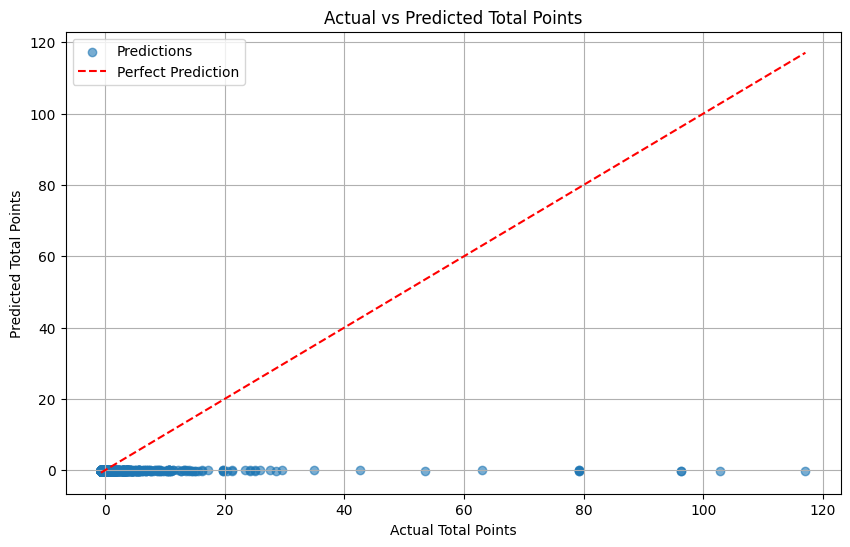

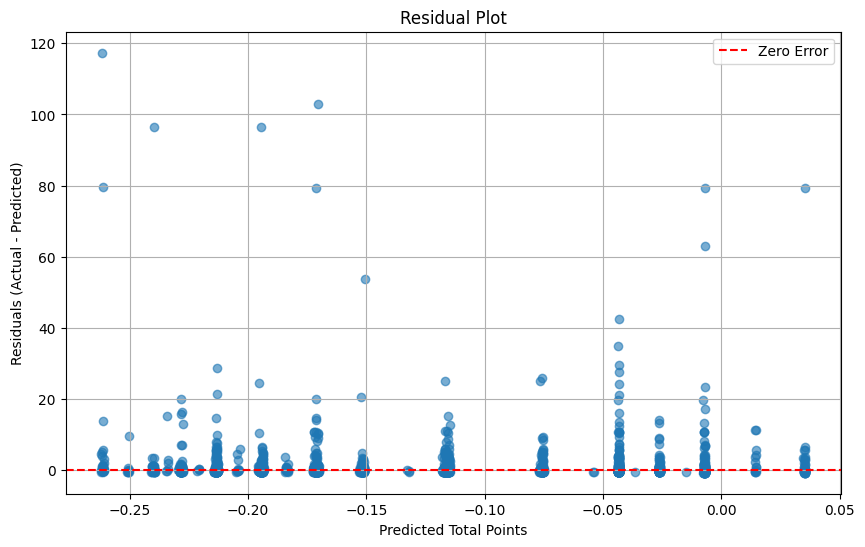

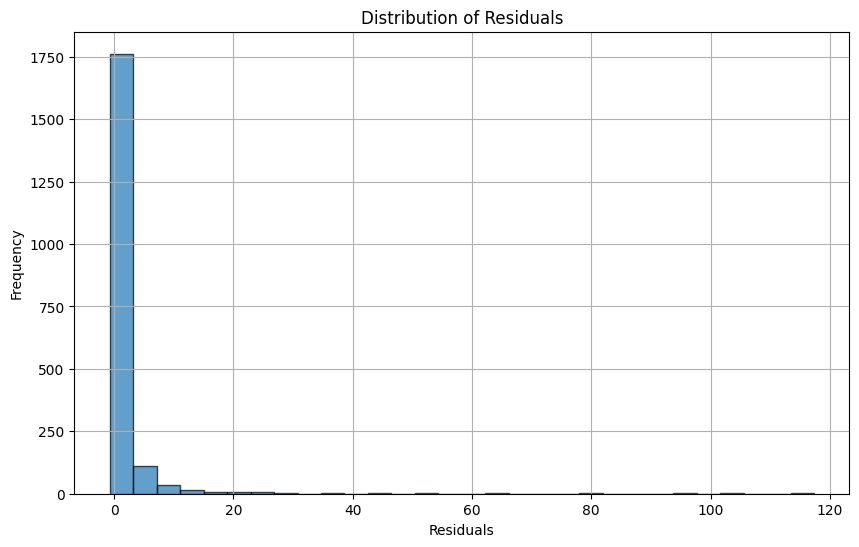


Residual Analysis:
- Residuals are positively biased, indicating the model tends to under-predict.
- The residual histogram helps assess if errors are normally distributed, which is ideal.


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(all_preds, all_targets):
    # Transform predictions and targets back to original scale
    all_preds_exp = np.expm1(all_preds)
    all_targets_exp = np.expm1(all_targets)

    # Calculate metrics
    mae = mean_absolute_error(all_targets_exp, all_preds_exp)
    mse = mean_squared_error(all_targets_exp, all_preds_exp)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets_exp, all_preds_exp)
    accuracy = np.mean((all_preds_exp / all_targets_exp) * 100)

    # Print metrics
    print("Model Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")
    print(f"Accuracy (%): {accuracy:.2f}")

    # Key Findings
    print("\nKey Findings:")
    if mae < 20:
        print("- The Mean Absolute Error (MAE) suggests good alignment between predictions and actual values.")
    else:
        print("- High MAE indicates room for improvement in prediction accuracy.")
    if r2 > 0.5:
        print("- The R² score indicates the model explains a good portion of variance in the target variable.")
    else:
        print("- Low R² score suggests the model is underfitting or missing important predictive features.")
    if accuracy > 90:
        print("- High accuracy indicates the model performs well on the validation set.")
    else:
        print("- Accuracy below 90% suggests potential overfitting or insufficient generalization.")

    # Plot Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(all_targets_exp, all_preds_exp, alpha=0.6, label="Predictions")
    plt.plot([all_targets_exp.min(), all_targets_exp.max()], [all_targets_exp.min(), all_targets_exp.max()], 'r--', label="Perfect Prediction")
    plt.xlabel("Actual Total Points")
    plt.ylabel("Predicted Total Points")
    plt.title("Actual vs Predicted Total Points")
    plt.legend()
    plt.grid()
    plt.show()

    # Residual Plot
    residuals = all_targets_exp - all_preds_exp
    plt.figure(figsize=(10, 6))
    plt.scatter(all_preds_exp, residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--', label="Zero Error")
    plt.xlabel("Predicted Total Points")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residual Plot")
    plt.legend()
    plt.grid()
    plt.show()

    # Residual Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='k')
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Distribution of Residuals")
    plt.grid()
    plt.show()

    # Residual Insights
    print("\nResidual Analysis:")
    if np.mean(residuals) > 0:
        print("- Residuals are positively biased, indicating the model tends to under-predict.")
    elif np.mean(residuals) < 0:
        print("- Residuals are negatively biased, indicating the model tends to over-predict.")
    else:
        print("- Residuals are balanced, indicating unbiased predictions on average.")
    print("- The residual histogram helps assess if errors are normally distributed, which is ideal.")

# Call this function with predictions and targets from validation
# Example usage (ensure you have already obtained all_preds and all_targets from validation):
evaluate_model(val_preds, val_targets)


Evaluating: 100%|██████████| 613/613 [01:04<00:00,  9.56it/s]


Model Performance Metrics:
Mean Absolute Error (MAE): 35.96
Mean Squared Error (MSE): 2249.10
Root Mean Squared Error (RMSE): 47.42
R-squared (R2): -1.33
Accuracy (%): nan


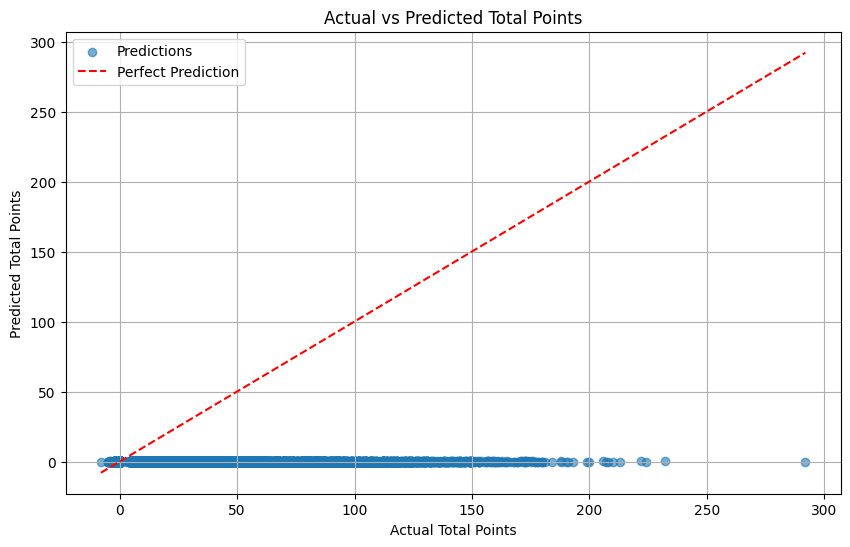

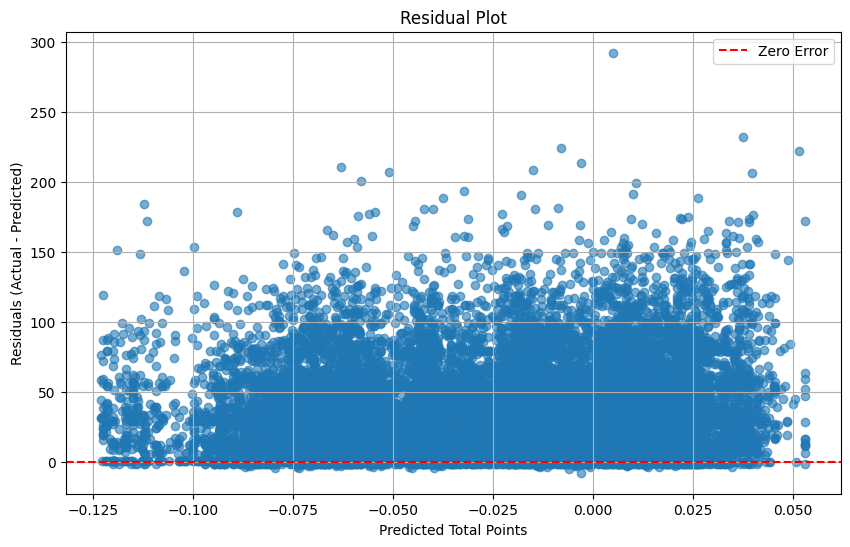

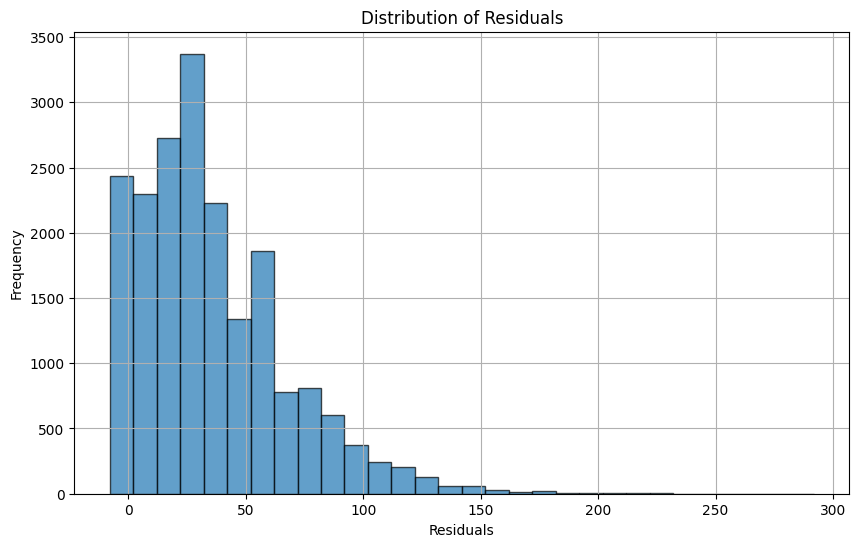

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
from tqdm import tqdm

# Load the best trained model
BEST_MODEL_PATH = "best_model.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define function to preprocess for evaluation
def preprocess_for_evaluation(data, tokenizer, max_len):
    """Prepare data for evaluation."""
    tokenized_insights = tokenizer(
        data['Insights'].tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors="pt"
    )

    metrics_embeddings = torch.tensor(data['Metrics_embeddings'].tolist(), dtype=torch.float)
    insights_embeddings = torch.tensor(data['Insights_embeddings'].tolist(), dtype=torch.float)
    arguments_embeddings = torch.tensor(data['Arguments_embeddings'].tolist(), dtype=torch.float)
    numerical_features = torch.tensor(data['match_performance_scaled'].values, dtype=torch.float).unsqueeze(1)
    targets = torch.tensor(data['total_points'].values, dtype=torch.float)

    return tokenized_insights, metrics_embeddings, insights_embeddings, arguments_embeddings, numerical_features, targets

# Load model and tokenizer
model = AdvancedTransformerModel(transformer_name='bert-base-uncased', 
                                 num_numerical_features=1,
                                 embedding_size=768).to(device)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()

# Preprocess evaluation data
tokenized_insights, metrics_embeddings, insights_embeddings, arguments_embeddings, numerical_features, targets = preprocess_for_evaluation(
    merged_data, tokenizer, MAX_LEN
)

# Perform evaluation
with torch.no_grad():
    batch_size = 32
    predictions = []
    actuals = []
    for i in tqdm(range(0, len(merged_data), batch_size), desc="Evaluating"):
        batch_input_ids = tokenized_insights['input_ids'][i:i+batch_size].to(device)
        batch_attention_mask = tokenized_insights['attention_mask'][i:i+batch_size].to(device)
        batch_metrics_embeddings = metrics_embeddings[i:i+batch_size].to(device)
        batch_insights_embeddings = insights_embeddings[i:i+batch_size].to(device)
        batch_arguments_embeddings = arguments_embeddings[i:i+batch_size].to(device)
        batch_numerical_features = numerical_features[i:i+batch_size].to(device)
        batch_targets = targets[i:i+batch_size].to(device)

        batch_outputs = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask,
            numerical_features=batch_numerical_features,
            metrics_embeddings=batch_metrics_embeddings,
            insights_embeddings=batch_insights_embeddings,
            arguments_embeddings=batch_arguments_embeddings
        )
        predictions.append(batch_outputs.squeeze(-1).cpu().numpy())
        actuals.append(batch_targets.cpu().numpy())

# Combine predictions and actuals
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Calculate metrics
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actuals, predictions)
accuracy = np.mean((predictions / actuals) * 100)

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Accuracy (%): {accuracy:.2f}")

# Visualization
# 1. Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.6, label="Predictions")
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Actual vs Predicted Total Points")
plt.legend()
plt.grid()
plt.show()

# 2. Residual Plot
residuals = actuals - predictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', label="Zero Error")
plt.xlabel("Predicted Total Points")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.legend()
plt.grid()
plt.show()

# 3. Residual Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='k')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid()
plt.show()

## Hemant


In [26]:
import pandas as pd

# Load the CSV file into a DataFrame
csv_file = '/kaggle/input/player-names-correlation/player_names_new_updated2.csv'
df = pd.read_csv(csv_file, sep=',')

# Print column names for debugging
print("Columns in CSV:", df.columns.tolist())

# Ensure correct column names by stripping whitespace
df.columns = df.columns.str.strip()

# Check if 'Match_1' exists in the DataFrame
if 'Match_1' not in df.columns:
    raise KeyError("'Match_1' column not found in the CSV file")

# Filter rows where Match_1 is filled
filled_df = df[df['Match_1'].notna()]

# Filter rows where Match_1 is not filled
not_filled_df = df[df['Match_1'].isna()]

# Create a dictionary from the filled DataFrame
player_dict = filled_df.set_index('player_name')['Match_1'].to_dict()

# Save the not filled DataFrame to a new CSV file
not_filled_df.to_csv('/kaggle/working/2008-2022_not_filled.csv', index=False, sep='\t')

# Output the dictionary
print(player_dict)

Columns in CSV: ['player_name', 'Match_1']
{'Shane_Warne': 'SK Warne', 'Brett_Lee': 'B Lee', 'Adam_Gilchrist': 'AC Gilchrist', 'Rohit_Sharma': 'RG Sharma', 'Kevin_Pietersen': 'KP Pietersen', 'Dimitri_Mascarenhas': 'AD Mascarenhas', 'Daniel_Vettori': 'DL Vettori', 'Scott_Styris': 'SB Styris', 'Andrew_Symonds': 'A Symonds', 'David_Hussey': 'DJ Hussey', 'Virat_Kohli': 'V Kohli', 'Ricky_Ponting': 'RT Ponting', 'Praveen_Kumar': 'P Kumar', 'Matthew_Hayden': 'ML Hayden', 'Harbhajan_Singh': 'Harbhajan Singh', 'Michael_Clarke': 'MJ Clarke', 'Andrew_Flintoff': 'A Flintoff', 'Shane_Bond': 'SE Bond', 'Ishant_Sharma': 'I Sharma', 'Mahendra_Singh_Dhoni': 'MS Dhoni', 'Glenn_McGrath': 'GD McGrath', 'Stephen_Fleming': 'SP Fleming', 'Aakash_Chopra': 'A Chopra', 'Cheteshwar_Pujara': 'CA Pujara', 'Lasith_Malinga': 'SL Malinga', 'Sanath_Jayasuriya': 'ST Jayasuriya', 'Dilhara_Fernando': 'CRD Fernando', 'Mike_Hussey': 'MEK Hussey', 'Ross_Taylor': 'LRPL Taylor', 'Rahul_Dravid': 'R Dravid', 'Wasim_Jaffer': 'W 

In [27]:
import pandas as pd

# Load the dictionary from the previous step
player_dict = {
'Shane_Warne': 'SK Warne', 'Brett_Lee': 'B Lee', 'Adam_Gilchrist': 'AC Gilchrist', 'Rohit_Sharma': 'RG Sharma', 'Kevin_Pietersen': 'KP Pietersen', 'Dimitri_Mascarenhas': 'AD Mascarenhas', 'Daniel_Vettori': 'DL Vettori', 'Scott_Styris': 'SB Styris', 'Andrew_Symonds': 'A Symonds', 'David_Hussey': 'DJ Hussey', 'Virat_Kohli': 'V Kohli', 'Ricky_Ponting': 'RT Ponting', 'Praveen_Kumar': 'P Kumar', 'Matthew_Hayden': 'ML Hayden', 'Harbhajan_Singh': 'Harbhajan Singh', 'Michael_Clarke': 'MJ Clarke', 'Andrew_Flintoff': 'A Flintoff', 'Shane_Bond': 'SE Bond', 'Ishant_Sharma': 'I Sharma', 'Mahendra_Singh_Dhoni': 'MS Dhoni', 'Glenn_McGrath': 'GD McGrath', 'Stephen_Fleming': 'SP Fleming', 'Aakash_Chopra': 'A Chopra', 'Cheteshwar_Pujara': 'CA Pujara', 'Lasith_Malinga': 'SL Malinga', 'Sanath_Jayasuriya': 'ST Jayasuriya', 'Dilhara_Fernando': 'CRD Fernando', 'Mike_Hussey': 'MEK Hussey', 'Ross_Taylor': 'LRPL Taylor', 'Rahul_Dravid': 'R Dravid', 'Wasim_Jaffer': 'W Jaffer', 'Shoaib_Akhtar': 'Shoaib Akhtar', 'Mohammad_Asif': 'Mohammad Asif', 'Tatenda_Taibu': 'T Taibu', 'Muttiah_Muralitharan': 'M Muralitharan', 'Mahela_Jayawardene': 'DPMD Jayawardene', 'Yuvraj_Singh': 'Yuvraj Singh', 'Graeme_Smith': 'GC Smith', 'Shahid_Afridi': 'Shahid Afridi', 'Chaminda_Vaas': 'WPUJC Vaas', 'Nuwan_Zoysa': 'DNT Zoysa', 'Chamara_Silva': 'LPC Silva', 'Darren_Lehmann': 'DS Lehmann', 'Sachin_Tendulkar': 'SR Tendulkar', 'Michael_Hussey': 'MEK Hussey', 'Brendon_McCullum': 'BB McCullum', 'Sourav_Ganguly': 'SC Ganguly', 'Sunil_Joshi': 'SB Joshi', 'Irfan_Pathan': 'IK Pathan', 'Sreesanth': 'S Sreesanth', 'Brad_Haddin': 'BJ Haddin', 'Mitchell_Johnson': 'MG Johnson', 'Chris_Gayle': 'CH Gayle', 'Shivnarine_Chanderpaul': 'S Chanderpaul', 'Ramnaresh_Sarwan': 'RR Sarwan', 'Justin_Kemp': 'JM Kemp', 'Azhar_Mahmood': 'Azhar Mahmood', 'Dwayne_Bravo': 'DJ Bravo', 'Jacques_Kallis': 'JH Kallis', 'Mark_Boucher': 'MV Boucher', 'Shaun_Pollock': 'SM Pollock', 'Virender_Sehwag': 'V Sehwag', 'Pradeep_Sangwan': 'PJ Sangwan', 'Yo_Mahesh': 'VY Mahesh', 'Ashley_Noffke': 'AA Noffke', 'Shahrukh_Khan': 'M Shahrukh Khan', 'Zaheer_Khan': 'Z Khan', 'Dale_Steyn': 'DW Steyn', 'Cameron_White': 'CL White', 'Jacob_Oram': 'JDP Oram', 'Luke_Ronchi': 'L Ronchi', 'Luke_Pomersbach': 'LA Pomersbach', 'VVS_Laxman': 'VVS Laxman', 'Uday_Kaul': 'U Kaul', 'Sunny_Sohal': 'S Sohal', 'Pankaj_Dharmani': 'P Dharmani', 'Wilkin_Mota': 'WA Mota', 'Shaun_Marsh': 'SE Marsh', 'Dominic_Thornely': 'DJ Thornely', 'Simon_Katich': 'SM Katich', 'Makhaya_Ntini': 'M Ntini', 'Herschelle_Gibbs': 'HH Gibbs', 'Ajit_Agarkar': 'AB Agarkar', 'Robin_Uthappa': 'RV Uthappa', 'JP_Duminy': 'JP Duminy', 'L_Balaji': 'L Balaji', 'S_Badrinath': 'S Badrinath', 'Dinesh_Karthik': 'KD Karthik', 'R_Ashwin': 'R Ashwin', 'Anil_Kumble': 'A Kumble', 'Shoaib_Malik': 'Shoaib Malik', 'Younis_Khan': 'Younis Khan', 'RP_Singh': 'RP Singh', 'Luke_Wright': 'LJ Wright', 'Suresh_Raina': 'SK Raina', 'Abhishek_Nayar': 'AM Nayar', 'Misbah-ul-Haq': 'Misbah-ul-Haq', 'Shane Watson': 'SR Watson', 'Mohammad Ashraful': 'Mohammad Ashraful', 'Luke Pomersbach': 'LA Pomersbach', 'Brad Hodge': 'BJ Hodge', 'James Hopes': 'JR Hopes', 'Farveez_Maharoof': 'MF Maharoof', 'Ashish_Nehra': 'A Nehra', 'Amit_Mishra': 'A Mishra', 'Mithun_Manhas': 'M Manhas', 'Rajat_Bhatia': 'R Bhatia', 'Shikhar_Dhawan': 'S Dhawan', 'Viraat_Kohli': 'V Kohli', 'Tanmay_Srivastava': 'TM Srivastava', 'Matty_Hayden': 'ML Hayden', 'Umar_Gul': 'Umar Gul', 'Gautam_Gambhir': 'G Gambhir', 'Manpreet_Gony': 'MS Gony', 'Kumar_Sangakkara': 'KC Sangakkara', 'Dinesh_Salunkhe': 'D Salunkhe', 'Shane_Watson': 'SR Watson', 'Brad_Hodge': 'BJ Hodge', 'Manoj_Tiwary': 'MK Tiwary', 'AB_de_Villiers': 'AB de Villiers', 'Farvez_Maharoof': 'MF Maharoof', 'Tillekaratne_Dilshan': 'TM Dilshan', 'Brett_Geeves': 'B Geeves', 'Parthiv_Patel': 'PA Patel', 'Musavir_Khote': 'MA Khote', 'Yusuf_Pathaan': 'YK Pathan', 'Wriddhiman_Saha': 'WP Saha', 'Laxmi_Ratan_Shukla': 'LR Shukla', 'Misbah-ul_Haq': 'Misbah-ul-Haq', 'Ashok_Dinda': 'AB Dinda', 'B_Akhil': 'B Akhil', 'VRV_Singh': 'VRV Singh', 'Pragyan_Ojha': 'PP Ojha', 'Joginder_Sharma': 'Joginder Sharma', 'Mahesh_Rawat': 'M Rawat', 'Yusuf_Pathan': 'YK Pathan', 'Albie_Morkel': 'JA Morkel', 'Chamara_Kapugedera': 'CK Kapugedera', 'Venugopal_Rao': 'Y Venugopal Rao', 'Karan_Goel': 'K Goel', 'Piyush_Chawla': 'PP Chawla', 'James_Hopes': 'JR Hopes', 'Irfan_Pathaan': 'IK Pathan', 'Ravindra_Jadeja': 'RA Jadeja', 'Munaf_Patel': 'MM Patel', 'Salman_Butt': 'Salman Butt', 'Debabrata_Das': 'DB Das', 'Bharat_Chipli': 'B Chipli', 'Abdur_Razzaq': 'Abdur Razzak', 'Dwayne_Smith': 'DR Smith', 'Palani_Amarnath': 'P Amarnath', 'Swapnil_Asnodkar': 'SA Asnodkar', 'Dhawal_Kulkarni': 'DS Kulkarni', 'Andre_Nel': 'A Nel', 'Siddharth_Trivedi': 'SK Trivedi', 'Kamran_Akmal': 'Kamran Akmal', 'Sohail_Tanvir': 'Sohail Tanvir', 'Sean_Marsh': 'SE Marsh', 'Shivnaraine_Chanderpaul': 'S Chanderpaul', 'Mohammad_Hafeez': 'Mohammad Hafeez', 'J_Arunkumar': 'J Arunkumar', 'Vijaykumar_Yo_Mahesh': 'VY Mahesh', 'Ranadeb_Bose': 'RR Bose', 'Yusuf_Patham': 'YK Pathan', 'Chamara_Kapugedara': 'CK Kapugedera', 'Ajantha_Mendis': 'BAW Mendis', 'Ramesh_Powar': 'RR Powar', 'Samit_Patel': 'MM Patel', 'Yogesh_Takawale': 'YV Takawale', 'Shivanarine_Chanderpaul': 'S Chanderpaul', 'Bikash_Gony': 'MS Gony', 'Bishan_Powar': 'RR Powar', 'Yusuf_Pathán': 'YK Pathan', 'Tillakaratne_Dilshan': 'TM Dilshan', 'Nuwan_Maharoof': 'MF Maharoof', 'Ryan_Harris': 'RJ Harris', 'Abdur_Razzak': 'Abdur Razzak', 'Irfan_Patham': 'IK Pathan', 'Stuart_Binny': 'STR Binny', 'Ambati_Rayudu': 'AT Rayudu', 'Graham_Napier': 'GR Napier', 'Moises_Henriques': 'MC Henriques', 'David_Warner': 'DA Warner', 'Vinay_Kumar': 'R Vinay Kumar', 'Sanju_Samson': 'SV Samson', 'Sreevats_Goswami': 'SP Goswami', 'Niraj_Patel': 'NK Patel', 'Kamran_Khan': 'Z Khan', 'S_Vidyut': 'S Vidyut', 'S_Anirudha': 'S Anirudha', 'Murali': 'M Muralitharan', 'Shakib_Al_Hasan': 'Shakib Al Hasan', 'R_Vinay_Kumar': 'R Vinay Kumar', 'Shoaib_Akhter': 'Shoaib Akhtar', 'Rohan_Raje': 'RR Raje', 'Angelo_Mathews': 'AD Mathews', 'Shaun_Tait': 'SW Tait', 'Murali_Kartik': 'M Kartik', 'Shane_Harwood': 'SM Harwood', 'Muhammad_Asif': 'Mohammad Asif', 'Fidel_Edwards': 'FH Edwards', 'Naman_Ojha': 'NV Ojha', 'Raiphi_Gomez': 'RV Gomez', 'Tyron_Henderson': 'T Henderson', 'Jesse_Ryder': 'JD Ryder', 'Paul_Collingwood': 'PD Collingwood', 'Tim_Southee': 'TG Southee', 'Mohammad_Kaif': 'M Kaif', 'Mashrafe_Mortaza': 'Mashrafe Mortaza', 'Mohammad_Ashraful': 'Mohammad Ashraful', 'George_Bailey': 'GJ Bailey', 'Jerome_Taylor': 'LRPL Taylor', 'Imran_Khan': 'Z Khan', 'Chamra_Kapugedera': 'CK Kapugedera', 'Dirk_Nannes': 'DP Nannes', 'Andrew_McDonald': 'AB McDonald', 'Robin_Peterson': 'RJ Peterson', 'Rob_Quiney': 'RJ Quiney', 'Lee_Carseldine': 'LA Carseldine', 'Mohammed_Hafeez': 'Mohammad Hafeez', 'MS_Dhoni': 'MS Dhoni', 'Shoaib_Aktar': 'Shoaib Akhtar', 'Lakshmipathy_Balaji': 'L Balaji', 'Flintoff': 'A Flintoff', 'Pietersen': 'KP Pietersen', 'Duminy': 'JP Duminy', 'Mortaza': 'Mashrafe Mortaza', 'Mohammed_Kaif': 'M Kaif', 'Ajinkya_Rahane': 'AM Rahane', 'Pinal_Shah': 'PR Shah', 'Morne_Morkel': 'JA Morkel', 'Kieran_Pollard': 'KA Pollard', 'Mathew_Hayden': 'ML Hayden', 'Paras_Dogra': 'P Dogra', 'Henderson': 'T Henderson', 'Sambit_Bal': 'L Balaji', 'MS_Gony': 'MS Gony', 'Srikkanth_Anirudha': 'S Anirudha', 'Abhinav_Mukund': 'A Mukund', 'Johan_Botha': 'J Botha', 'Roelof_van_der_Merwe': 'RE van der Merwe', 'Laxmi_Shukla': 'LR Shukla', 'Umesh_Yadav': 'UT Yadav', 'Bhuvneshwar_Kumar': 'B Kumar', 'Amit_Singh': 'A Singh', 'Misbah_ul_Haq': 'Misbah-ul-Haq', 'van_der_Merwe': 'RE van der Merwe', 'Dillon_du_Preez': 'D du Preez', 'Azharuddin_Bilkahia': 'AA Bilakhia', 'Sanjay_Bangar': 'SB Bangar', 'Sangakkara': 'KC Sangakkara', 'AB_de_villiers': 'AB de Villiers', 'Rohan_Gavaskar': 'RS Gavaskar', 'Azhar_Bilakhia': 'AA Bilakhia', 'Shadab_Jakati': 'SB Jakati', 'Badrinath': 'S Badrinath', 'Morne_van_Wyk': 'MN van Wyk', 'Subramaniam_Badrinath': 'S Badrinath', 'Abhishek_Raut': 'AS Raut', 'T_Suman': 'TL Suman', 'Chandan_Madan': 'C Madan', 'Sanath_Jayasurya': 'ST Jayasuriya', 'Eoin_Morgan': 'EJG Morgan', 'Misbah_ul-Haq': 'Misbah-ul-Haq', 'Shreevats_Goswami': 'SP Goswami', 'VS_Malik': 'Shoaib Malik', 'Manish_Pandey': 'MK Pandey', 'Yusuf_Pathak': 'YK Pathan', 'Wayne_Parnell': 'WD Parnell', 'Kieron_Pollard': 'KA Pollard', 'Ryan_McLaren': 'R McLaren', 'Kemar_Roach': 'KAJ Roach', 'Mitchell_Marsh': 'MR Marsh', 'Monish_Mishra': 'MD Mishra', 'Rahul_Sharma': 'R Sharma', 'Steve_Smith': 'SPD Smith', 'Abhimanyu_Mithun': 'A Mithun', 'KP': 'KP Pietersen', 'Dmitri_Mascarenhas': 'AD Mascarenhas', 'Michael_Lumb': 'MJ Lumb', 'Saurabh_Tiwary': 'SS Tiwary', 'Aditya_Tare': 'AP Tare', 'Juan_Theron': 'J Theron', 'Fazal': 'FY Fazal', 'Abhishek_Jhunjhunwala': 'AA Jhunjhunwala', 'Steven_Smith': 'SPD Smith', 'Damien_Martyn': 'DR Martyn', 'Thissara_Perera': 'NLTC Perera', 'Mohnish_Mishra': 'MD Mishra', 'Jaydev_Unadkat': 'JD Unadkat', 'Manvinder_Bisla': 'MS Bisla', 'Sarabjit_Ladda': 'S Ladda', 'R_Sathish': 'R Sathish', 'Sudeep_Tyagi': 'S Tyagi', 'Thissaara_Perera': 'NLTC Perera', 'Adam_Voges': 'AC Voges', 'Amit_Uniyal': 'A Uniyal', 'Love_Ablish': 'L Ablish', 'Ishant_Sharm': 'I Sharma', 'Varun_Aaron': 'VR Aaron', 'Sophie_Tiwary': 'MK Tiwary', 'Aaron_Finch': 'AJ Finch', 'Doug_Bollinger': 'DE Bollinger', 'Murali_Muralitharan': 'M Muralitharan', 'Sumit_Narwal': 'S Narwal', 'Faiz_Fazal': 'FY Fazal', 'Kedar_Jadhav': 'KM Jadhav', 'Yogesh_Nagar': 'Y Nagar', 'Shane_Tait': 'SW Tait', 'Shalabh_Srivastava': 'SJ Srivastava', 'Manoj_Bisla': 'MS Bisla', 'Yusuf_Pathana': 'YK Pathan', 'Thilan_Thushara': 'T Thushara', 'Aditya_Dole': 'AP Dole', 'Narwal': 'S Narwal', 'Badrinath_S': 'S Badrinath', 'Tilakaratne_Dilshan': 'TM Dilshan', 'Murali_Vijay': 'M Vijay', 'Chris_Watson': 'SR Watson', 'Lumb': 'MJ Lumb', 'Siddarth_Trivedi': 'SK Trivedi', 'Kohli': 'V Kohli', 'Uthappa': 'RV Uthappa', 'Barath': 'AB Barath', 'Jaidev_Unadkat': 'JD Unadkat', 'Adrian_Barath': 'AB Barath', 'Bopara': 'RS Bopara', 'Y_Venugopal_Rao': 'Y Venugopal Rao', 'Irfan_Pathane': 'IK Pathan', 'Ravichandran_Ashwin': 'R Ashwin', 'Adam_Symonds': 'A Symonds', 'M_Dhoni': 'MS Dhoni', 'Tirumalasetti_Suman': 'TL Suman', 'Angelo_Matthews': 'AD Mathews', 'S_Sreesanth': 'S Sreesanth', 'Niranjan_Shah': 'PR Shah', 'Pankaj_Singh': 'Pankaj Singh', 'Anirudh_Singh': 'Yuvraj Singh', 'Sridharan_Sriram': 'S Sriram', 'Adam Gilchrist': 'AC Gilchrist', 'Shane Warne': 'SK Warne', 'Paul_Valthaty': 'PC Valthaty', 'Murali_Jayawardene': 'DPMD Jayawardene', 'Rashwin_Ashwin': 'R Ashwin', 'M_S_Dhoni': 'MS Dhoni', 'Alfonso_Thomas': 'AC Thomas', 'Shrikant_Wagh': 'SB Wagh', 'Davy_Jacobs': 'DJ Jacobs', 'David_Miller': 'DA Miller', 'Nuwan_Kulasekara': 'KMDN Kulasekara', 'Shahbaz_Nadeem': 'S Nadeem', 'Daniel_Christian': 'DT Christian', 'Anirudha': 'S Anirudha', 'S_Aravind': 'S Aravind', 'Michael_Klinger': 'M Klinger', 'Prasanth_Parameswaran': 'P Parameswaran', 'Iqbal_Abdulla': 'Iqbal Abdulla', 'Amit_Paunikar': 'AG Paunikar', 'Vikramjeet_Singh_Malik': 'VS Malik', 'Suraj_Randiv': 'S Randiv', 'Dougie_Bollinger': 'DE Bollinger', 'Ashok_Menaria': 'AL Menaria', 'Aiden_Blizzard': 'AC Blizzard', 'Matthew_Wade': 'MS Wade', 'Sreenath_Aravind': 'S Aravind', 'Siddharth_Chitnis': 'SD Chitnis', 'Mandeep_Singh': 'Mandeep Singh', 'Abu_Nechim': 'AN Ahmed', 'Mayank_Agarwal': 'MA Agarwal', 'Thisara_Perera': 'NLTC Perera', 'Travis_Birt': 'TR Birt', 'M_Manvinder_Bisla': 'MS Bisla', 'Tim_Paine': 'TD Paine', 'James_Faulkner': 'JP Faulkner', 'Shrikant_Mundhe': 'SS Mundhe', 'Bodipati_Sumanth': 'B Sumanth', 'Ryan_ten_Doeschate': 'RN ten Doeschate', 'Trivedi': 'SK Trivedi', 'Colin_Ingram': 'CA Ingram', 'Glenn_Maxwell': 'GJ Maxwell', 'Yusuf_Pathān': 'YK Pathan', 'Muthiah_Muralitharan': 'M Muralitharan', 'James_Taylor': 'LRPL Taylor', 'Callum_Ferguson': 'CJ Ferguson', 'Marlon_Samuels': 'MN Samuels', 'Richard_Levi': 'RE Levi', 'Suryakumar_Yadav': 'SA Yadav', 'Unmukt_Chand': 'UBT Chand', 'Sunil_Narine': 'SP Narine', 'Pawan_Negi': 'P Negi', 'Manprit_Juneja': 'MC Juneja', 'S_Sriram': 'S Sriram', 'Rajesh_Pawar': 'RV Pawar', 'Tanmay_Mishra': 'A Mishra', 'Biplab_Samantray': 'BB Samantray', 'TP_Sudhindra': 'TP Sudhindra', 'Akshath_Reddy': 'PA Reddy', 'Andre_Russell': 'AD Russell', 'Rajats_Bhatia': 'R Bhatia', 'Johan_van_der_Wath': 'JJ van der Wath', 'Kevon_Cooper': 'KK Cooper', 'Deepak_Chahar': 'DL Chahar', 'Doug_Bracewell': 'DAJ Bracewell', 'David_White': 'CL White', 'Harshal_Patel': 'HV Patel', 'Rahul_Shukla': 'LR Shukla', 'Kuldeep_Yadav': 'Kuldeep Yadav', 'Imran_Tahir': 'Imran Tahir', 'Brad_Hogg': 'GB Hogg', 'Marchant_de_Lange': 'M de Lange', 'Anand_Rajan': 'Anand Rajan', 'Mitch_Marsh': 'MR Marsh', 'Ben_Hilfenhaus': 'BW Hilfenhaus', 'Kyle_Abbott': 'KJ Abbott', 'Ben_Cutting': 'BCJ Cutting', 'Samuel_Badree': 'S Badree', 'Kevin_Cooper': 'KK Cooper', 'Faf_du_Plessis': 'F du Plessis', 'Vijay_Zol': 'VH Zol', 'KP_Appanna': 'KP Appanna', 'Karun_Nair': 'KK Nair', 'Gurkeerat_Singh': 'Gurkeerat Singh', 'Parvinder_Awana': 'P Awana', 'Yousuf_Pathan': 'YK Pathan', 'Ishank_Jaggi': 'IR Jaggi', 'Ashish_Reddy': 'A Ashish Reddy', 'Ishwar_Pandey': 'IC Pandey', 'Shakib_Al_Hassan': 'Shakib Al Hasan', 'adam_gilchrist': 'AC Gilchrist', 'chris_gayle': 'CH Gayle', 'sunil_narine': 'SP Narine', 'Ravi_Rampaul': 'R Rampaul', 'Alex_Hales': 'AD Hales', 'CM_Gautam': 'CM Gautam', 'Ankeet_Chavan': 'AA Chavan', 'Ajit_Chandila': 'A Chandila', 'Ankit_Chavan': 'AA Chavan', 'Nathan_Coulter-Nile': 'NM Coulter-Nile', 'Aniket_Choudhary': 'A Choudhary', 'Ravi_Teja': 'DB Ravi Teja', 'Chris_Morris': 'CH Morris', 'Tanvir': 'Sohail Tanvir', 'Sachithra_Senanayake': 'SMSM Senanayake', 'Kane_Richardson': 'KW Richardson', 'Anustup_Majumdar': 'AP Majumdar', 'Rilee_Rossouw': 'RR Rossouw', 'James_Pattinson': 'JL Pattinson', 'Mitchell_Starc': 'JL Pattinson', 'Dishant_Yagnik': 'DH Yagnik', 'Ankit_Rajpoot': 'AS Rajpoot', 'Mohit_Sharma': 'MM Sharma', 'Ronit_More': 'RG More', 'Maharoof': 'MF Maharoof', 'Chris_Lynn': 'CA Lynn', 'Francois_du_Plessis': 'F du Plessis', 'Rahane': 'AM Rahane', 'Azhar_Ali': 'M Muralitharan', 'Manoj_Tewary': 'MK Tiwary', 'Janine_Kallis': 'JH Kallis', 'Sourabh_Tiwary': 'SS Tiwary', 'Darren_Sammy': 'DJG Sammy', 'Mahendra_Dhoni': 'MS Dhoni', 'Kumara_Sangakkara': 'KC Sangakkara', 'Robin_Petersen': 'RJ Peterson', 'Roelof_van_Der_Merwe': 'RE van der Merwe', 'Martin_Guptill': 'MJ Guptill', 'Robinson_Uthappa': 'RV Uthappa', 'Akila_Dananjaya': 'A Dananjaya', 'Freddie_Flintoff': 'A Flintoff', 'P_Amarnath': 'P Amarnath', 'Manan_Vohra': 'M Vohra', 'Sandeep_Sharma': 'Sandeep Sharma', 'Quinton_de_Kock': 'Q de Kock', 'Sachin_Baby': 'Sachin Baby', 'Jeevan_Mendis': 'BMAJ Mendis', 'Clint_McKay': 'CJ McKay', 'Manpreet_Singh_Gony': 'MS Gony', 'Saurav_Ganguly': 'SC Ganguly', 'Kallis': 'JH Kallis', 'Hashim_Amla': 'HM Amla', 'Kusal_Perera': 'MDKJ Perera', 'Jasprit_Bumrah': 'JJ Bumrah', 'KL_Rahul': 'KL Rahul', 'Hanuma_Vihari': 'GH Vihari', 'Parwinder_Awana': 'P Awana', 'Rishi_Dhawan': 'R Dhawan', 'Akhila_Dhananjaya': 'A Dananjaya', 'Glen_McGrath': 'GD McGrath', 'Brendan_McCullum': 'BB McCullum', 'Aavishkar_Salvi': 'AM Salvi', 'Michael_Neser': 'MG Neser', 'Parvez_Rasool': 'Parvez Rasool', 'Chandila': 'A Chandila', 'Chavan': 'AA Chavan', 'Pravin_Tambe': 'PV Tambe', 'Corey_Anderson': 'CJ Anderson', 'David_Willey': 'DJ Willey', 'Jason_Holder': 'JO Holder', 'Shikhar_Dhawon': 'S Dhawan', 'Karn_Sharma': 'KV Sharma', 'Ben_Stokes': 'BA Stokes', 'Jos_Buttler': 'JC Buttler', 'Siddarth_Kaul': 'S Kaul', 'Ben_Rohrer': 'BJ Rohrer', 'Lasi_Malinga': 'SL Malinga', 'Tait': 'SW Tait', 'Dan_Christian': 'DT Christian', 'Robin_Utappa': 'RV Uthappa', 'Iqbal_Abdullah': 'Iqbal Abdulla', 'Yuzvendra_Chahal': 'YS Chahal', 'Warner': 'DA Warner', 'Sehwag': 'V Sehwag', 'Nadeem': 'S Nadeem', 'Yusuf_PathAN': 'YK Pathan', 'Nic_Maddinson': 'NJ Maddinson', 'Pat_Cummins': 'PJ Cummins', 'Jimmy_Neesham': 'JDS Neesham', 'Krishmar_Santokie': 'K Santokie', 'Ambati_Rayadu': 'AT Rayudu', 'Rampaul': 'R Rampaul', 'Mohammed_Shami': 'Mohammed Shami', 'Yuvaraj_Singh': 'Yuvraj Singh', 'AB_De_Villiers': 'AB de Villiers', 'Sachitra_Senanayake': 'SMSM Senanayake', 'Akshar_Patel': 'AR Patel', 'Shreyas_Iyer': 'SS Iyer', 'Yusuf_Pathank': 'YK Pathan', 'François_du_Plessis': 'F du Plessis', 'Lendl_Simmons': 'LMP Simmons', 'Rahul_Tewatia': 'R Tewatia', 'Darren_Smith': 'DR Smith', 'Karanveer_Singh': 'Karanveer Singh', 'Pawan_Suyal': 'P Suyal', 'KC_Cariappa': 'KC Cariappa', 'Trent_Boult': 'TA Boult', 'Jayant_Yadav': 'J Yadav', 'Milind_Kumar': 'P Kumar', 'James_Faulker': 'JP Faulkner', 'Ben_Dunk': 'BR Dunk', 'Deepak_Hooda': 'DJ Hooda', 'Gurinder_Sandhu': 'GS Sandhu', 'Pardeep_Sahu': 'P Sahu', 'Mitch_Johnson': 'MG Johnson', 'Sarfaraz_Khan': 'SN Khan', 'Kane_Williamson': 'KS Williamson', 'Hardik_Pandya': 'HH Pandya', 'James_Neesham': 'JDS Neesham', 'Vijay_Shankar': 'V Shankar', 'Ravi_Ashwin': 'R Ashwin', 'Shardul_Thakur': 'SN Thakur', 'David_Wiese': 'D Wiese', 'Adam_Milne': 'AF Milne', 'Sean_Abbott': 'SA Abbott', 'Domnic_Joseph_Muthuswami': 'DJ Muthuswami', 'Beuran_Hendricks': 'BE Hendricks', 'Colin_Munro': 'C Munro', 'Shreyas_Gopal': 'S Gopal', 'Mohammad_Shami': 'Mohammed Shami', 'DPMD_Jayawardene': 'DPMD Jayawardene', 'JH_Kallis': 'JH Kallis', 'Dave_Warner': 'DA Warner', 'Surya_Yadav': 'SA Yadav', 'Taruwar_Kohli': 'T Kohli', 'Siddhesh_Lad': 'SD Lad', 'Mitchell_McClenaghan': 'MJ McClenaghan', 'Trent_Boulton': 'TA Boult', 'Matt_Henry': 'MJ Henry', 'Brainder_Sran': 'BB Sran', 'Chris_Woakes': 'CR Woakes', 'John_Hastings': 'JW Hastings', 'Axar_Patel': 'AR Patel', 'Praveen_Kumaris': 'P Kumar', 'Bhuvneshwar_Kumaris': 'B Kumar', 'Abu_Nechim_Ahmed': 'AN Ahmed', 'Viru_paaji': 'V Sehwag', 'LMP_Simmons': 'LMP Simmons', 'DA_Warner': 'DA Warner', 'SK_Raina': 'SK Raina', 'DR_Smith': 'DR Smith', 'BB_McCullum': 'BB McCullum', 'AM_Rahane': 'AM Rahane', 'AJ_Finch': 'AJ Finch', 'A_Rayudu': 'AT Rayudu', 'J_Suchith': 'J Suchith', 'Kieron_Polland': 'KA Pollard', 'Krunal_Pandya': 'KH Pandya', 'Josh_Hazlewood': 'JR Hazlewood', 'Praveen_Tambe': 'PV Tambe', 'Ab_De_Villiers': 'AB de Villiers', 'Suchith_J': 'J Suchith', 'Khaleel_Ahmed': 'KK Ahmed', 'M_Ashwin': 'M Ashwin', 'Ishan_Kishan': 'Ishan Kishan', 'Carlos_Brathwaite': 'CR Brathwaite', 'Tabraiz_Shamsi': 'T Shamsi', 'Usman_Khawaja': 'UT Khawaja', 'Yusuf_Pathans': 'YK Pathan', 'Jagadeesha_Suchith': 'J Suchith', 'Marcus_Stoinis': 'MP Stoinis', 'Mustafizur_Rahman': 'Mustafizur Rahman', 'Travis_Head': 'TM Head', 'Sam_Billings': 'SW Billings', 'Peter_Handscomb': 'PSP Handscomb', 'Andrew_Tye': 'AJ Tye', 'Adam_Zampa': 'A Zampa', 'Faf_du Plessis': 'F du Plessis', 'Barinder_Sran': 'BB Sran', 'Swapnil_Singh': 'Swapnil Singh', 'Sheldon_Jackson': 'SP Jackson', 'Akshdeep_Nath': 'AD Nath', 'Shivil_Kaushik': 'S Kaushik', 'Kagiso_Rabada': 'K Rabada', 'Rishabh_Pant': 'RR Pant', 'Tymal_Mills': 'TS Mills', 'Mahipal_Lomror': 'MK Lomror', 'Chris_Jordan': 'CJ Jordan', 'Mark_Wood': 'MA Wood', 'Dhoni': 'MS Dhoni', 'Jaydev_Undakat': 'JD Unadkat', 'Rashid_Khan': 'Rashid Khan', 'T_Natarajan': 'T Natarajan', 'Mohammed_Siraj': 'Mohammed Siraj', 'Farhaan_Behardien': 'F Behardien', 'Nitish_Rana': 'N Rana', 'Heinrich_Klaasen': 'H Klaasen', 'M_Stoinis': 'MP Stoinis', 'R_Jadeja': 'RA Jadeja', 'U_Yadav': 'UT Yadav', 'Basil_Thampi': 'Basil Thampi', 'K_Gowtham': 'K Gowtham', 'Mohammad_Nabi': 'Mohammad Nabi', 'Billy_Stanlake': 'B Stanlake', 'Murugan_Ashwin': 'M Ashwin', 'Usman_Khwaja': 'UT Khawaja', 'Tabrez_Shamsi': 'T Shamsi', 'Kedhar_Jadhav': 'KM Jadhav', 'Sanju_Sampson': 'SV Samson', 'Vishnu_Vinod': 'Vishnu Vinod', 'Colin_de_Grandhomme': 'C de Grandhomme', 'Ricky_Bhui': 'RK Bhui', 'Rahul_Tripathi': 'RA Tripathi', 'Tejas_Baroka': 'Tejas Baroka', 'Washington_Sundar': 'Washington Sundar', 'Eklavya_Dwivedi': 'ER Dwivedi', 'Rahul_Chahar': 'RD Chahar', 'TheFizz': 'Mustafizur Rahman', 'Ankit_Soni': 'Ankit Soni', 'Lockie_Ferguson': 'LH Ferguson', 'Nitesh_Rana': 'N Rana', 'Liam_Livingstone': 'LS Livingstone', 'Ben_Laughlin': 'B Laughlin', 'Jason_Roy': 'JJ Roy', 'Mohammad_Siraj': 'Mohammed Siraj', 'Jason_Behrendorff': 'JP Behrendorff', 'Wriddhman_Saha': 'WP Saha', 'Viru_Sehwag': 'V Sehwag', 'Kamlesh_Nagarkoti': 'KL Nagarkoti', 'Shubman_Gill': 'Shubman Gill', 'Prithvi_Shaw': 'PP Shaw', 'Liam_Plunkett': 'LE Plunkett', 'Rohit_Sharm': 'RG Sharma', 'Ankit_Bawne': 'AR Bawne', 'Lungi_Ngidi': 'L Ngidi', 'Sandep_Sharma': 'Sandeep Sharma', 'Mujeeb_Ur_Rahman': 'Mujeeb Ur Rahman', 'Priyam_Garg': 'PK Garg', 'Jofra_Archer': 'JC Archer', 'Tom_Curran': 'TK Curran', 'Prasidh_Krishna': 'M Prasidh Krishna', 'Mitchell_Santner': 'MJ Santner', 'Jasprit_Unadkat': 'JD Unadkat', 'Mayank_Markande': 'M Markande', 'Shivam_Mavi': 'Shivam Mavi', 'Sandeep_Lamichhane': 'S Lamichhane', 'Varun_Chakravarthy': 'CV Varun', 'Ish_Sodhi': 'IS Sodhi', 'Muhammad_Mujeeb_Ur_Rahman': 'Mujeeb Ur Rahman', "D'Arcy_Short": 'DJM Short', 'K Gowtham': 'K Gowtham', 'Jofra Archer': 'JC Archer', 'Jasprit Bumrah': 'JJ Bumrah', 'Suryakumar Yadav': 'SA Yadav', 'Harshal': 'HV Patel', 'Dushmantha_Chameera': 'PVD Chameera', 'Jonny_Bairstow': 'JM Bairstow', 'Moeen_Ali': 'MM Ali', 'Evin_Lewis': 'E Lewis', 'Navdeep_Saini': 'N Saini', 'Harry_Gurney': 'HF Gurney', 'Kulwant_Khejroliya': 'K Khejroliya', 'Avesh_Khan': 'Avesh Khan', 'Abhishek_Sharma': 'Abhishek Sharma', 'Krishnappa_Gowtham': 'K Gowtham', 'Alzarri_Joseph': 'AS Joseph', 'Faf_Du_Plessis': 'F du Plessis', 'Dhruv_Shorey': 'DR Shorey', 'Kshitiz_Sharma': 'I Sharma', 'N_Jagadeesan': 'N Jagadeesan', 'Mahela_Jayawardena': 'DPMD Jayawardene', 'Rassie_van_der_Dussen': 'HE van der Dussen', 'Riley_Meredith': 'RP Meredith', 'Anrich_Nortje': 'A Nortje', 'Sandeep_Warrier': 'S Sandeep Warrier', 'Siddharth_Kaul': 'S Kaul', 'Mujeeb_ur_Rahman': 'Mujeeb Ur Rahman', 'Mithali_Raj': 'RR Raje', 'Jhulan_Goswami': 'SP Goswami', 'AB_de_Viliers': 'AB de Villiers', 'Faf_du_Plesis': 'F du Plessis', 'Mahesh_Kumar': 'P Kumar', 'Sam_Curran': 'SM Curran', 'Surya_Kumar_Yadav': 'SA Yadav', 'Rasikh_Salam': 'Rasikh Salam', 'Devdutt_Padikkal': 'D Padikkal', 'Shimron_Hetmyer': 'SO Hetmyer', 'Oshane_Thomas': 'O Thomas', 'Shivam_Dube': 'S Dube', 'Joe_Denly': 'JL Denly', 'Tushar_Deshpande': 'TU Deshpande', 'Glenn_Phillips': 'GD Phillips', 'Mohammed_Shammi': 'Mohammed Shami', 'Rabada_Kagiso': 'K Rabada', 'Rasikh_Dar': 'Rasikh Salam', 'Ashton_Turner': 'AJ Turner', 'Riyan_Parag': 'R Parag', 'Prashant_Chopra': 'P Chopra', 'Rinku_Singh': 'RK Singh', 'Venkatesh_Iyer': 'VR Iyer', 'Ruturaj_Gaikwad': 'RD Gaikwad', 'KS_Bharat': 'KS Bharat', 'Rajat_Patidar': 'RM Patidar', 'Yashasvi_Jaiswal': 'YBK Jaiswal', 'Dwaine_Pretorius': 'D Pretorius', 'Jhye_Richardson': 'JA Richardson', 'Umran_Malik': 'Umran Malik', 'Morris': 'CH Morris', 'Sherfane_Rutherford': 'SE Rutherford', 'Keemo_Paul': 'KMA Paul', 'Sarfaraz_Khande': 'SN Khan', 'Odean_Smith': 'OF Smith', 'Harpreet_Brar': 'Harpreet Brar', 'Livingstone': 'LS Livingstone', 'Mohsin_Khan': 'Mohsin Khan', 'Mujeeb-ur-Rahman': 'Mujeeb Ur Rahman', 'Rohit_Shama': 'RG Sharma', 'Finn_Allen': 'FA Allen', 'Chetan_Sakariya': 'C Sakariya', 'Nicholas_Pooran': 'N Pooran', 'Kartik_Tyagi': 'Kartik Tyagi', 'Collin_Munro': 'C Munro', 'Abdul_Samad': 'Abdul Samad', 'Ravi_Bishnoi': 'Ravi Bishnoi', 'Arshdeep_Singh': 'Arshdeep Singh', 'Lalit_Yadav': 'Lalit Yadav', 'Aiden_Markram': 'AK Markram', 'Tim_Seifert': 'TL Seifert', 'Rovman_Powell': 'R Powell', 'Daniel_Sams': 'DR Sams', 'Dawid_Malan': 'DJ Malan', 'Shahbaz_Ahmed': 'Shahbaz Ahmed', 'Cameron_Green': 'CJ Green', 'Romario_Shepherd': 'R Shepherd', 'Ayush_Badoni': 'A Badoni', 'Kyle_Jamieson': 'KA Jamieson', 'Prayas_Ray_Barman': 'P Ray Barman', 'Hardus_Viljoen': 'GC Viljoen', 'Yusuf_Pathani': 'YK Pathan', 'Vaibhav_Arora': 'VG Arora', 'B_Sai_Sudharsan': 'B Sai Sudharsan', 'Litton_Das': 'DB Das', 'Wanindu_Hasaranga': 'PWH de Silva', 'Akash_Deep': 'Akash Deep', 'Kuggeleijn': 'SC Kuggeleijn', 'Nathan_Ellis': 'NT Ellis', 'Bhanuka_Rajapaksa': 'PBB Rajapaksa', 'Tim_David': 'TH David', 'Tilak_Varma': 'Tilak Varma', 'Yash_Dayal': 'Yash Dayal', 'Mukesh_Choudhary': 'Mukesh Choudhary', 'Maheesh_Theekshana': 'M Theekshana', 'Matheesha_Pathirana': 'M Pathirana', 'Suyash_Sharma': 'I Sharma', 'M_Shahrukh_Khan': 'M Shahrukh Khan', 'Alex_Carey': 'AT Carey', 'Jos_Butler': 'JC Buttler', 'Jitesh_Sharma': 'JM Sharma'
}

# Load the CSV file
csv_file = '/kaggle/input/sentiment-data-1/player_performance_with_embeddings_final1_updated_final.csv'
df = pd.read_csv(csv_file, sep=',')

# Ensure correct column names by stripping whitespace
df.columns = df.columns.str.strip()

# Update the player_name column using the dictionary
df['player_name'] = df['player_name'].replace(player_dict)

# Save the updated DataFrame to a new CSV file
df.to_csv('/kaggle/working/player_performance_with_embeddings_final1_updated_final-updated.csv', index=False, sep=',')

# Output the updated DataFrame
print(df.head())

       player_name                                            Metrics  \
0  Mohammad_Yousuf  Pending IPL participation due to ICL contract ...   
1         SK Warne  Notable player with a strong leadership role; ...   
2            B Lee  No specific metrics provided; known for fast b...   
3     AC Gilchrist  Retirement from international cricket; partici...   
4        RG Sharma  Excellent batting technique, capable of powerf...   

                                            Insights  \
0  Known for aggressive batting style; past recor...   
1  Experienced franchise leader with vast cricket...   
2  Former fast bowler, strong T20 presence, exper...   
3  Explosive wicketkeeper-batsman; strong Twenty2...   
4  Modern cricket citizen, strong technique, effe...   

                                           Arguments  match_performance  \
0  Negative sentiment due to ongoing legal challe...               0.00   
1  Positively impacts team dynamics; potential ch...               0.80   

In [28]:
import pandas as pd

# Load the main CSV file
csv_file = '/kaggle/working/player_performance_with_embeddings_final1_updated_final-updated.csv'
df = pd.read_csv(csv_file, sep=',')

# Ensure correct column names by stripping whitespace
df.columns = df.columns.str.strip()

# Load the CSV with names to remove
remove_file = '/kaggle/input/reference-csv-hemant-do-not-touch/2008-2022_not_filled.csv'
remove_df = pd.read_csv(remove_file, sep=',', names=['player_name'])

# Strip whitespace from player names in the removal list
remove_names = remove_df['player_name'].str.strip().tolist()

# Filter out rows where player_name matches any name in remove_names
df = df[~df['player_name'].isin(remove_names)]

# Save the updated DataFrame to a new CSV file
df.to_csv('/kaggle/working/player_performance_with_embeddings_final1_updated_final-updated-final-to-be-worked-with.csv', index=False, sep=',')

# Output the updated DataFrame
print(df.head())

    player_name                                            Metrics  \
1      SK Warne  Notable player with a strong leadership role; ...   
2         B Lee  No specific metrics provided; known for fast b...   
3  AC Gilchrist  Retirement from international cricket; partici...   
4     RG Sharma  Excellent batting technique, capable of powerf...   
5  KP Pietersen  High profile England batsman, known for a stro...   

                                            Insights  \
1  Experienced franchise leader with vast cricket...   
2  Former fast bowler, strong T20 presence, exper...   
3  Explosive wicketkeeper-batsman; strong Twenty2...   
4  Modern cricket citizen, strong technique, effe...   
5  Aggressive batting style, capable of big runs ...   

                                           Arguments  match_performance  \
1  Positively impacts team dynamics; potential ch...               0.80   
2  Positively framed; believes IPL could enhance ...               0.80   
3  Confident he w

# **Back to Maddy | Work with /kaggle/working/player_performance_with_embeddings_final1_updated_final-updated-final-to-be-worked-with.csv -> 5.05GB**